## Contents
- [Singularity](#singularity)
- [Manipulability ellipse](#manipulability-ellipse)
- [SVD and singular values](#svd-and-singular-values)
- [Damping near singularity (Damped Least-Squares IK](#damped-least-square)


# 🤖 Singularity  <a id="singularity"></a>

In robotics, a **singularity** is a configuration of a manipulator where the robot loses some of its degrees of freedom in the end-effector.  
That means the Jacobian matrix (which maps joint velocities to end-effector velocities) becomes singular — its determinant goes to zero, or one or more singular values collapse.  
$$
\dot x
= J(q)\dot q
$$

$$
\dot q
= J^+\dot x
$$

with

$$
J^+ = V \Sigma^{-1} U^T,  J = U \Sigma V^T
$$

At a singularity:
- Small joint motions may cause *no* movement at the end-effector (loss of mobility).
- Or the opposite: tiny joint motions may cause *very large* end-effector velocities (loss of stability and control).
- Path planning and control become tricky, since the inverse kinematics problem can blow up near these points.

Robots usually avoid singularities (or damp their effects) to maintain smooth, predictable motion.


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_two_link_arm(theta1, theta2, l1=1.0, l2=1.0):
    """
    Draw a simple 2-link planar arm.
    
    Parameters
    ----------
    theta1 : float
        Angle of the first joint (radians).
    theta2 : float
        Angle of the second joint (radians).
    l1 : float
        Length of the first link.
    l2 : float
        Length of the second link.
    """
    # Base at origin
    x0, y0 = 0, 0
    
    # First joint position
    x1 = x0 + l1 * np.cos(theta1)
    y1 = y0 + l1 * np.sin(theta1)
    
    # End effector position
    x2 = x1 + l2 * np.cos(theta1 + theta2)
    y2 = y1 + l2 * np.sin(theta1 + theta2)
    
    # Plot
    plt.figure(figsize=(5,5))
    plt.plot([x0, x1, x2], [y0, y1, y2], '-o', linewidth=4, markersize=10)
    plt.scatter([x0, x1, x2], [y0, y1, y2], color="red", zorder=5)
    plt.axis("equal")
    plt.grid(True)
    plt.xlim(- (l1+l2+0.5), (l1+l2+0.5))
    plt.ylim(- (l1+l2+0.5), (l1+l2+0.5))
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"2-Link Planar Arm\nθ1={np.degrees(theta1):.1f}°, θ2={np.degrees(theta2):.1f}°")
    plt.show()
    
    return (x2, y2)

In [9]:
def jacobian(theta1, theta2, l1=1.0, l2=1.0):
    J = np.array([
        [-l1*np.sin(theta1) - l2*np.sin(theta1+theta2), -l2*np.sin(theta1+theta2)],
        [ l1*np.cos(theta1) + l2*np.cos(theta1+theta2),  l2*np.cos(theta1+theta2)]
    ])
    return J

In [15]:
def fk_2link(theta1, theta2, l1=1.0, l2=1.0):
    """Forward kinematics for a 2-link planar arm. Returns (x0,y0),(x1,y1),(x2,y2)."""
    x0, y0 = 0.0, 0.0
    x1 = l1 * np.cos(theta1)
    y1 = l1 * np.sin(theta1)
    x2 = x1 + l2 * np.cos(theta1 + theta2)
    y2 = y1 + l2 * np.sin(theta1 + theta2)
    return (x0, y0), (x1, y1), (x2, y2)

In [16]:
# ---------- Manipulability ellipse ----------
def ellipse_from_J(J, center=(0.0, 0.0), n=200):
    """
    Return points of the velocity manipulability ellipse for ||qdot|| <= 1.
    The ellipse in task space satisfies xdot^T (J J^T)^{-1} xdot = 1.
    Axes lengths are sqrt(eigenvalues of JJ^T), directions are eigenvectors.
    """
    M = J @ J.T  # 2x2, symmetric PSD
    # Numerical guard in case we're at/near singularity
    eps = 1e-12
    # Eigen-decomposition
    evals, evecs = np.linalg.eigh(M + eps * np.eye(2))
    # Clamp to non-negative
    evals = np.maximum(evals, 0.0)

    # Radii of ellipse
    a, b = np.sqrt(evals)  # lengths of principal axes
    # Parametrize unit circle and map by E * diag([a,b])
    t = np.linspace(0, 2*np.pi, n)
    circle = np.vstack([np.cos(t), np.sin(t)])  # 2 x n
    ellipse = evecs @ np.diag([a, b]) @ circle
    ellipse[0, :] += center[0]
    ellipse[1, :] += center[1]
    return ellipse, (a, b), evecs

## Example Singularity position for 2-link planar robot

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


θ1=0.00, θ2=0.00, det(J)=0.0000


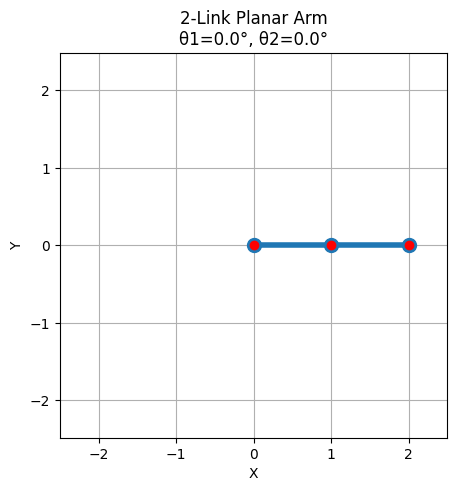

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


θ1=1.57, θ2=0.00, det(J)=0.0000


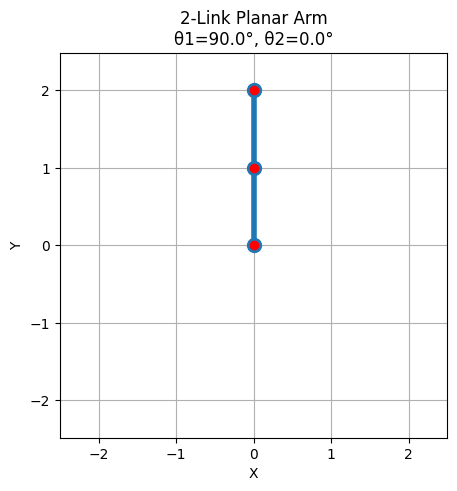

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


θ1=1.57, θ2=-1.57, det(J)=-1.0000


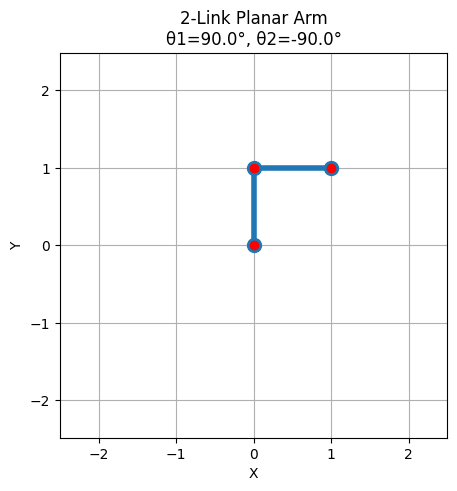

In [25]:
angles = [(0, 0), (np.pi/2, 0), (np.pi/2, -np.pi/2)]
for th1, th2 in angles:
    J = jacobian(th1, th2)
    print(f"θ1={th1:.2f}, θ2={th2:.2f}, det(J)={np.linalg.det(J):.4f}")    
    end_eff = plot_two_link_arm(theta1=th1, theta2=th2)


## Manipulability Ellipse <a id="manipulability-ellipse"></a>

The **manipulability ellipse** is a geometric way to describe how easily a robot’s end-effector can move in different directions given its current joint configuration.

- It comes from the Jacobian matrix, which links joint velocities to end-effector velocities.  
- If you imagine all possible unit joint motions, the Jacobian maps them into a region in task space.  
- That region is an ellipse (in 2D) or an ellipsoid (in 3D).  

**Interpretation:**
- Long axes → directions where the robot can move the end-effector quickly and with good control.  
- Short or collapsing axes → directions where the robot struggles to move (close to a singularity).  
- At a singularity, one axis of the ellipse shrinks to zero length, meaning the robot has lost mobility in that direction.

The manipulability ellipse is a handy diagnostic: big, round ellipses mean the robot is comfortable; skinny, flattened ones mean trouble is near.


In [18]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Kinematics ----------

def yoshikawa_manipulability(J):
    """Yoshikawa measure: w = sqrt(det(J J^T)). Zero at singularity."""
    JJt = J @ J.T
    det = np.linalg.det(JJt)
    return float(np.sqrt(max(det, 0.0)))

# ---------- Plot ----------
def plot_arm_with_ellipse(theta1, theta2, l1=1.0, l2=1.0, show_axes=True):
    (x0, y0), (x1, y1), (x2, y2) = fk_2link(theta1, theta2, l1, l2)
    J = jacobian(theta1, theta2, l1, l2)

    # Ellipse centered at the end-effector
    ellipse, axes, evecs = ellipse_from_J(J, center=(x2, y2))
    a, b = axes
    w = yoshikawa_manipulability(J)

    L = l1 + l2
    fig, ax = plt.subplots(figsize=(6, 6))
    # Links
    ax.plot([x0, x1, x2], [y0, y1, y2], '-o', linewidth=3, markersize=8)
    ax.scatter([x0, x1, x2], [y0, y1, y2], zorder=5)

    # Ellipse
    ax.plot(ellipse[0, :], ellipse[1, :], linewidth=2)

    # Show principal directions at EE, just to be extra clear
    if show_axes:
        origin = np.array([[x2], [y2]])
        # scale arrows by axes lengths for visibility
        vec1 = origin + evecs[:, [0]] * a
        vec2 = origin + evecs[:, [1]] * b
        ax.plot([x2, vec1[0, 0]], [y2, vec1[1, 0]], linestyle='--')
        ax.plot([x2, vec2[0, 0]], [y2, vec2[1, 0]], linestyle='--')

    ax.set_aspect('equal', adjustable='box')
    ax.grid(True)
    ax.set_xlim(-L - 0.5, L + 0.5)
    ax.set_ylim(-L - 0.5, L + 0.5)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title(
        f"2-Link Planar Arm with Manipulability Ellipse\n"
        f"θ1={np.degrees(theta1):.1f}°, θ2={np.degrees(theta2):.1f}° | "
        f"axes=({a:.3f}, {b:.3f}) | Yoshikawa w={w:.3f}"
    )
    plt.show()

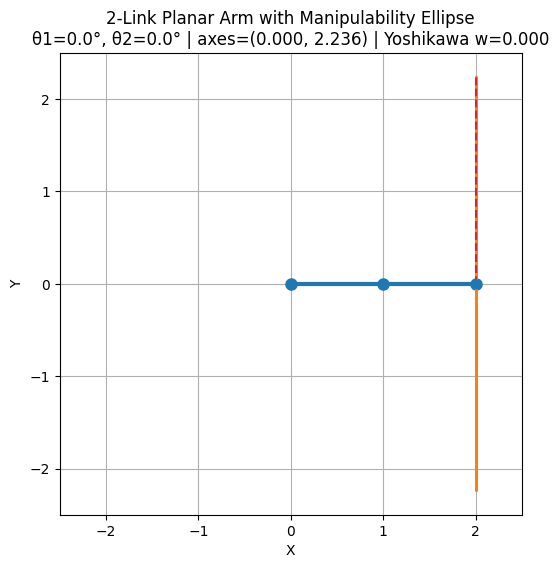

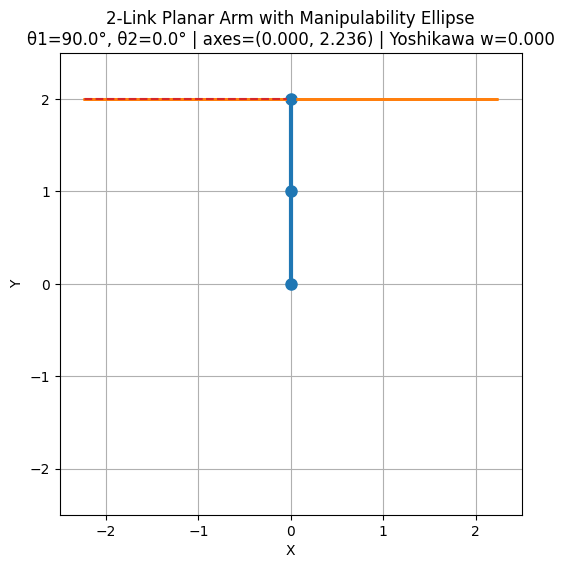

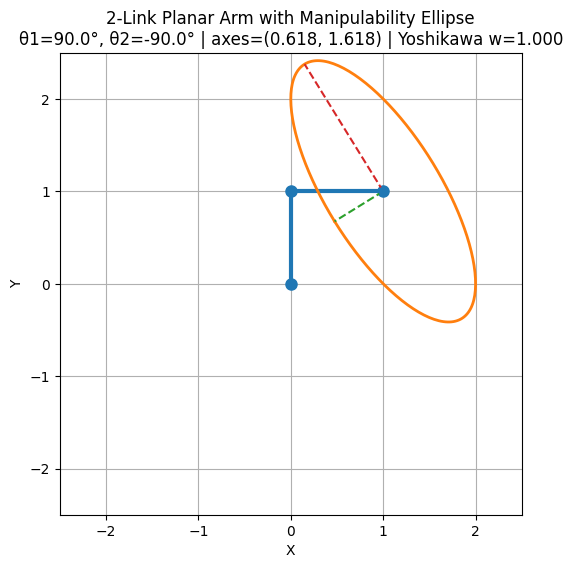

In [24]:
angles = [(0, 0), (np.pi/2, 0), (np.pi/2, -np.pi/2)]
for th1, th2 in angles:
    plot_arm_with_ellipse(theta1=th1, theta2=th2, l1=1.0, l2=1.0)

### Yoshikawa Manipulability Index (closeness to singularity) 

For a manipulator with Jacobian: $J(q)\in\mathbb{R}^{m\times n}\$, the **Yoshikawa index** is

$$
w(q) \;=\; \sqrt{\det\!\big(J(q)\,J(q)^\top\big)}
\;=\; \prod_{i=1}^{m} \sigma_i(q),
$$

where $sigma_i$ are the singular values of $J$.

**What it tells you**
- $w \ge 0$. $w=0$ **iff** the Jacobian loses rank → you are at a singularity.  
- As you approach a singularity, at least one $\sigma_i \to 0$ so $w \to 0$.  
- In 2D/3D task spaces, \(w\) is proportional to the **area/volume** of the velocity manipulability ellipse/ellipsoid.

**Caveats**
- Not a distance metric; different anisotropies can share the same $w$.  
  Collapses very fast, when one ellipse axes is almost zero metric itself can be ok. Hard to tune the value for damping.
- Scale-dependent: units depend on task and link lengths. For cross-robot comparisons, use a **normalized** variant (e.g., divide by a nominal $w_\text{ref}$ or insert joint-space weighting $W$: $w=\sqrt{\det(J W J^\top)}$).

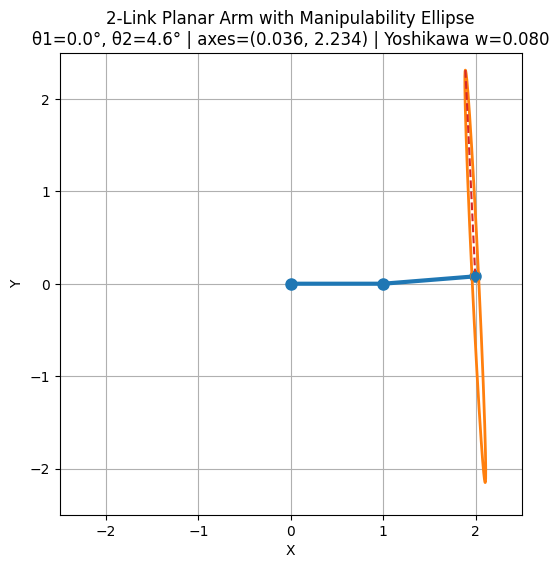

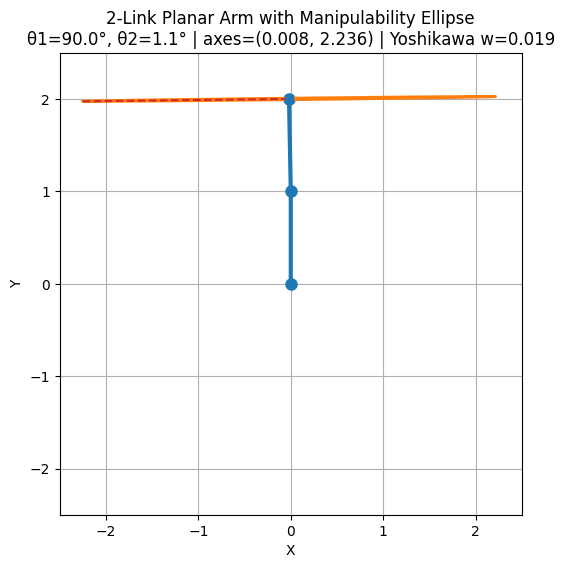

In [34]:
plot_arm_with_ellipse(theta1=0, theta2=0.08, l1=1.0, l2=1.0)
plot_arm_with_ellipse(theta1=np.pi/2, theta2=0.019, l1=1.0, l2=1.0)

### SVD to get the manipulability index (and each σ because you actually need them) <a id="svd-and-singular-values"></a>

Given a Jacobian $J(q) \in \mathbb{R}^{m\times n}$, take its **thin SVD**:
$$
J \;=\; U\,\Sigma\,V^\top,\qquad
\Sigma=\mathrm{diag}(\sigma_1,\dots,\sigma_m),\ \ \sigma_1\ge \cdots \ge \sigma_m \ge 0.
$$

- Each axis length is $\sigma_i$ are the singular values of $J$. 
- Geometrically, in an \(m\)-D task space, the axes of the velocity manipulability ellipsoid are exactly the $\sigma_i$.
- Near singularities, $\sigma_{\min}$ tells you everything you need to know about how close you are to the cliff.


In [42]:
def svd_sigmas(J: np.ndarray) -> np.ndarray:
    # singular values sorted descending
    return np.linalg.svd(J, compute_uv=False)

def yoshikawa_safe(J: np.ndarray, eps: float = 1e-15) -> float:
    # numerically safer near singularity: log-sum-exp style
    s = svd_sigmas(J)
    return float(np.exp(np.sum(np.log(s + eps))))


# ---------- Plot ----------
def plot_arm_with_ellipse(theta1, theta2, l1=1.0, l2=1.0, show_axes=True):
    (x0, y0), (x1, y1), (x2, y2) = fk_2link(theta1, theta2, l1, l2)
    J = jacobian(theta1, theta2, l1, l2)

    # Ellipse centered at the end-effector
    ellipse, axes, evecs = ellipse_from_J(J, center=(x2, y2))
    a, b = axes
    s = svd_sigmas(J)
    w = yoshikawa_safe(J)

    L = l1 + l2
    fig, ax = plt.subplots(figsize=(6, 6))
    # Links
    ax.plot([x0, x1, x2], [y0, y1, y2], '-o', linewidth=3, markersize=8)
    ax.scatter([x0, x1, x2], [y0, y1, y2], zorder=5)

    # Ellipse
    ax.plot(ellipse[0, :], ellipse[1, :], linewidth=2)

    # Show principal directions at EE, just to be extra clear
    if show_axes:
        origin = np.array([[x2], [y2]])
        # scale arrows by axes lengths for visibility
        vec1 = origin + evecs[:, [0]] * a
        vec2 = origin + evecs[:, [1]] * b
        ax.plot([x2, vec1[0, 0]], [y2, vec1[1, 0]], linestyle='--')
        ax.plot([x2, vec2[0, 0]], [y2, vec2[1, 0]], linestyle='--')

    ax.set_aspect('equal', adjustable='box')
    ax.grid(True)
    ax.set_xlim(-L - 0.5, L + 0.5)
    ax.set_ylim(-L - 0.5, L + 0.5)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title(
        f"2-Link Planar Arm with Manipulability Ellipse\n"
        f"θ1={np.degrees(theta1):.1f}°, θ2={np.degrees(theta2):.1f}° | "
        f"axes=({a:.3f}, {b:.3f}) | sigma=({s[0]:.3f}, {s[1]:.3f})"
        f"| Yoshikawa w={w:.3f}"
    )
    plt.show()

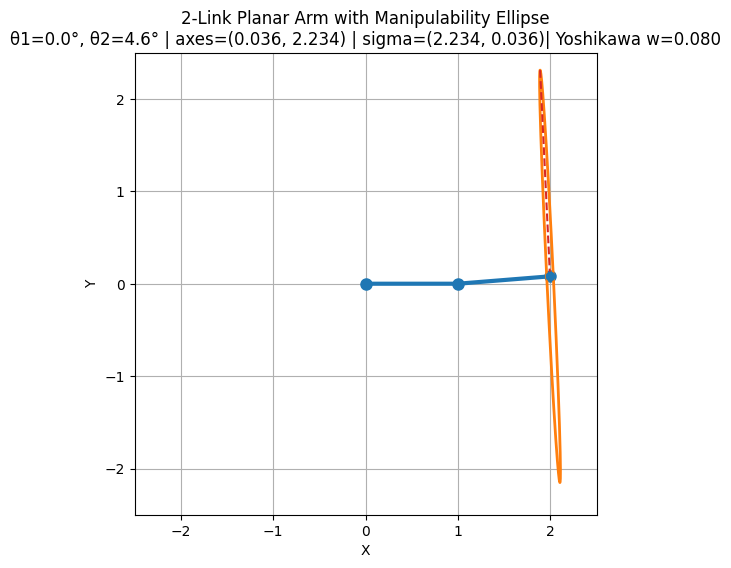

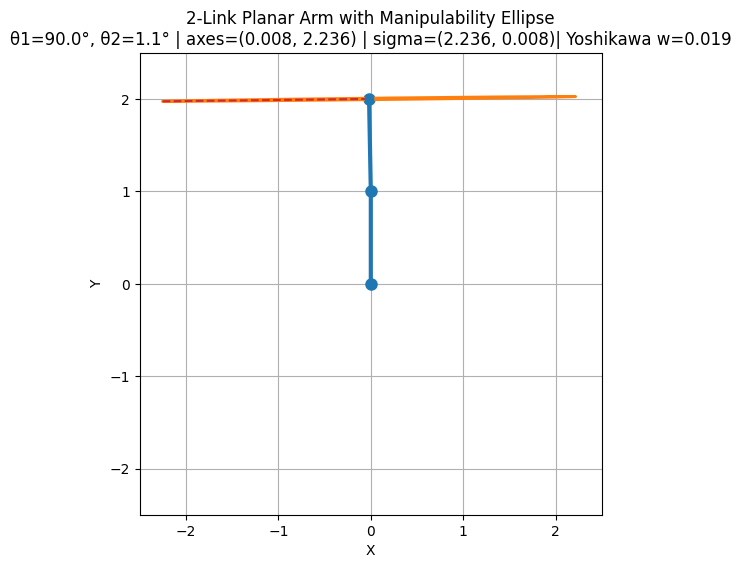

In [43]:
plot_arm_with_ellipse(theta1=0, theta2=0.08, l1=1.0, l2=1.0)
plot_arm_with_ellipse(theta1=np.pi/2, theta2=0.019, l1=1.0, l2=1.0)

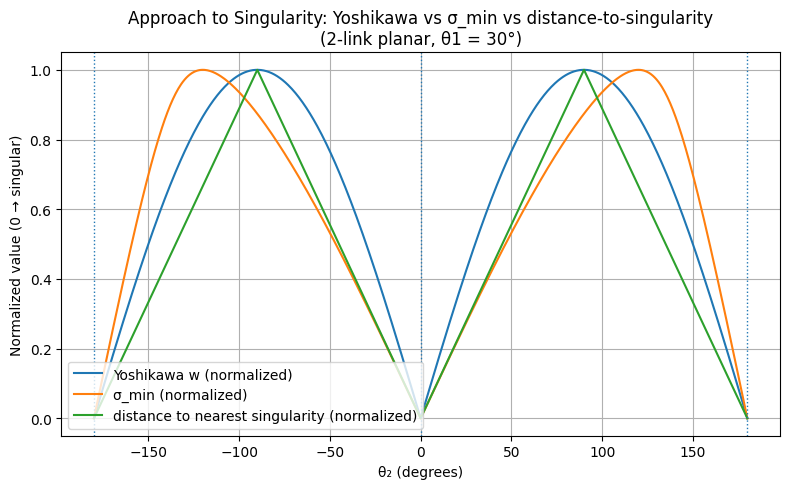

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# ---- 2-link planar arm ----
def jacobian_2link(theta1, theta2, l1=1.0, l2=1.0):
    s1, c1 = np.sin(theta1), np.cos(theta1)
    s12, c12 = np.sin(theta1 + theta2), np.cos(theta1 + theta2)
    J = np.array([
        [-l1*s1 - l2*s12,    -l2*s12],
        [ l1*c1 + l2*c12,     l2*c12]
    ])
    return J

def yoshikawa(J):
    JJt = J @ J.T
    det = np.linalg.det(JJt)
    return float(np.sqrt(max(det, 0.0)))

def sigma_min(J):
    s = np.linalg.svd(J, compute_uv=False)
    return float(s[-1])

# Distance in joint space to the nearest singular θ2 ∈ {0, π} (mod 2π).
# Normalized so that: 0 at singularity, 1 at the "safest" mid-point (|θ2| = π/2).
def distance_to_singularity(theta2):
    # wrap to [-pi, pi]
    t = ((theta2 + np.pi) % (2*np.pi)) - np.pi
    t = abs(t)  # now in [0, pi]
    d = min(t, np.pi - t)  # distance to {0, pi}
    return d / (np.pi/2)   # normalize to [0,1]

# ---- Sweep and plot ----
l1 = l2 = 1.0
theta1 = np.deg2rad(30.0)  # fix θ1; w depends only on θ2 for this arm, σ_min will still behave sensibly

theta2_grid = np.linspace(-np.pi, np.pi, 721)
w_vals = []
smin_vals = []
d_vals = []

for th2 in theta2_grid:
    J = jacobian_2link(theta1, th2, l1, l2)
    w_vals.append(yoshikawa(J))
    smin_vals.append(sigma_min(J))
    d_vals.append(distance_to_singularity(th2))

w_vals = np.array(w_vals)
smin_vals = np.array(smin_vals)
d_vals = np.array(d_vals)

# Normalize to [0,1] so everything sits nicely on one plot
w_norm = w_vals / (np.max(w_vals) if np.max(w_vals) > 0 else 1.0)
smin_norm = smin_vals / (np.max(smin_vals) if np.max(smin_vals) > 0 else 1.0)
dist_norm = d_vals  # already in [0,1]

# If you insist on plotting "closeness" instead of "distance",
# swap the next line for: closeness = 1 - dist_norm
distance_trace = dist_norm

x_deg = np.degrees(theta2_grid)

plt.figure(figsize=(8,5))
plt.plot(x_deg, w_norm, label="Yoshikawa w (normalized)")
plt.plot(x_deg, smin_norm, label="σ_min (normalized)")
plt.plot(x_deg, distance_trace, label="distance to nearest singularity (normalized)")

# mark singular lines θ2 = 0, ±π
for xline in [-180, 0, 180]:
    plt.axvline(x=xline, linestyle=":", linewidth=1)

plt.title("Approach to Singularity: Yoshikawa vs σ_min vs distance-to-singularity\n(2-link planar, θ1 = 30°)")
plt.xlabel("θ₂ (degrees)")
plt.ylabel("Normalized value (0 → singular)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Damping near singularity (Damped Least-Squares IK) <a id="damped-least-square"></a>

Goal. Stay numerically stable when the Jacobian $J(q)$ gets ill-conditioned or rank-deficient near a singularity.
$$
\dot x
= J(q)\dot q
$$

$$
\dot q
= J^+\dot x
$$

with

$$
J^+ = V \Sigma^{-1} U^T,  J = U \Sigma V^T
$$


**SVD view (what damping actually does)**

With $J = U \Sigma V^\top$, $\Sigma=\mathrm{diag}(\sigma_1,\dots,\sigma_m)$:
$$
\dot q
= \sum_{i=1}^{m}
\frac{\sigma_i}{\sigma_i^2 + \lambda^2}\,(u_i^\top v)\,v_i.
$$

So instead of dividing by a tiny singular value $\sigma_i$, you “dampen” it with $\lambda$ .If $\sigma_i$ is small, the denominator never gets close to zero. That keeps joint velocities finite, at the price of slightly reducing accuracy in task space.

Each mode is **shrunk** by $\frac{\sigma_i}{\sigma_i^2+\lambda^2}$.  
Near singularity $(\sigma_{\min}\to 0)$ those dangerous directions get heavily damped.



Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


User q (deg):   [0.00, 0.00]
DLS  q (deg):   [2.88, -3.04]
Final EE error: 1.079e-01


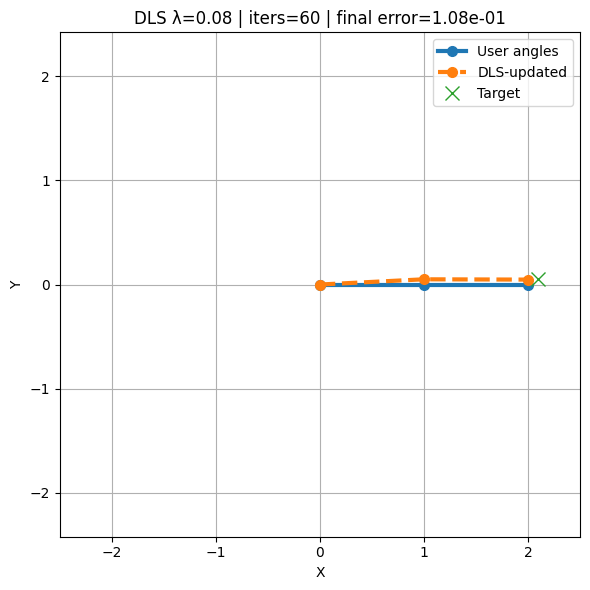

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


User q (deg):   [90.00, 0.00]
DLS  q (deg):   [90.00, 0.00]
Final EE error: 0.000e+00


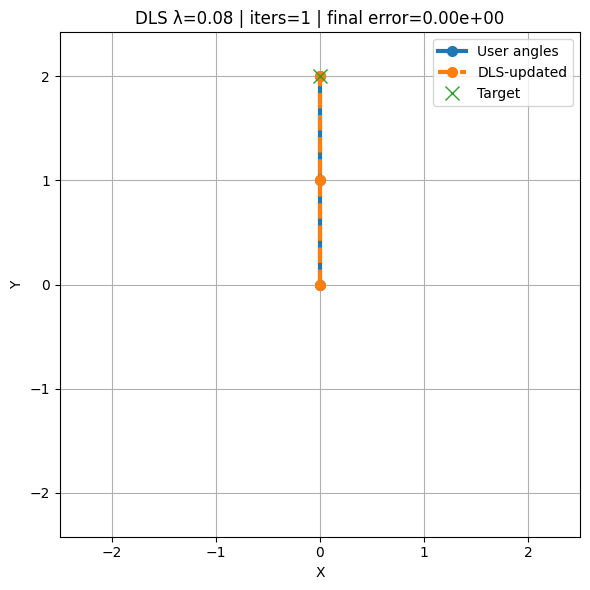

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


User q (deg):   [30.00, -40.00]
DLS  q (deg):   [17.50, -13.17]
Final EE error: 4.908e-07


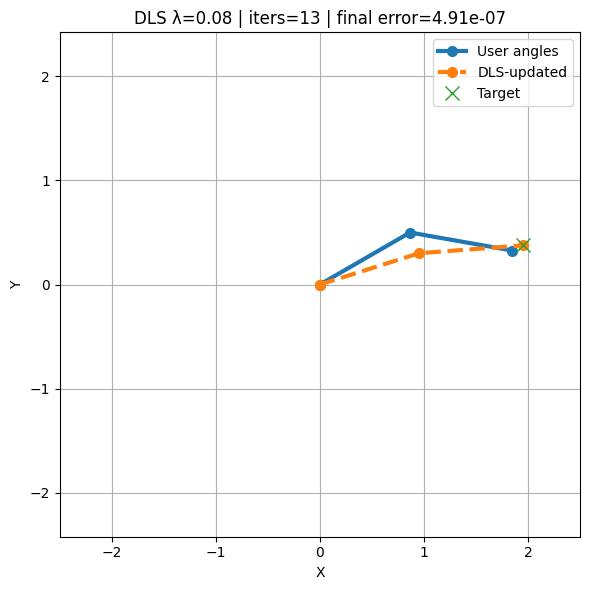

In [55]:
def fk_2link(q, l1=1.0, l2=1.0):
    """q = [theta1, theta2]. Returns joint positions [(x0,y0),(x1,y1),(x2,y2)]."""
    th1, th2 = q
    x0, y0 = 0.0, 0.0
    x1 = l1 * np.cos(th1)
    y1 = l1 * np.sin(th1)
    x2 = x1 + l2 * np.cos(th1 + th2)
    y2 = y1 + l2 * np.sin(th1 + th2)
    return (x0, y0), (x1, y1), (x2, y2)

def jacobian_2link(q, l1=1.0, l2=1.0):
    """Geometric Jacobian mapping [q1dot,q2dot] -> [xdot,ydot] at the end-effector."""
    th1, th2 = q
    s1, c1 = np.sin(th1), np.cos(th1)
    s12, c12 = np.sin(th1 + th2), np.cos(th1 + th2)
    J = np.array([
        [-l1*s1 - l2*s12,    -l2*s12],
        [ l1*c1 + l2*c12,     l2*c12]
    ])
    return J

# ---------- Damped Least Squares step ----------
def dls_step(q, target_xy, l1=1.0, l2=1.0, lam=0.05, step_clip=None):
    """
    One DLS IK step toward target_xy.
    q: [theta1, theta2]
    lam: damping (>= 0)
    step_clip: optional cap on |dq| (radians) to keep updates sane
    """
    (_, _), (_, _), (xe, ye) = fk_2link(q, l1, l2)
    e = np.array([target_xy[0] - xe, target_xy[1] - ye])  # task-space error (vx, vy)

    J = jacobian_2link(q, l1, l2)
    JJt = J @ J.T
    I = np.eye(2)
    # DLS: dq = J^T (JJ^T + λ^2 I)^-1 e
    dq = J.T @ np.linalg.solve(JJt + (lam**2) * I, e)

    if step_clip is not None:
        n = np.linalg.norm(dq)
        if n > step_clip and n > 0:
            dq = dq * (step_clip / n)
    return dq, e

def ik_dls(q0, target_xy, l1=1.0, l2=1.0, lam=0.05, iters=50, tol=1e-6, step_clip=0.25):
    """
    Iterative DLS to move EE to target_xy. Returns q_final, history dict.
    """
    q = np.array(q0, dtype=float)
    errs = []
    for _ in range(iters):
        dq, e = dls_step(q, target_xy, l1, l2, lam=lam, step_clip=step_clip)
        errs.append(np.linalg.norm(e))
        q = q + dq
        # keep angles reasonably wrapped (helps numerics/plots)
        q = (q + np.pi) % (2*np.pi) - np.pi
        if errs[-1] < tol:
            break
    return q, {"err_norm": np.array(errs)}

# ---------- Plotting ----------
def plot_two_arms(q_user, q_dls, target_xy, l1=1.0, l2=1.0, title=None):
    (x0a, y0a), (x1a, y1a), (x2a, y2a) = fk_2link(q_user, l1, l2)
    (x0b, y0b), (x1b, y1b), (x2b, y2b) = fk_2link(q_dls, l1, l2)

    L = l1 + l2
    plt.figure(figsize=(6,6))

    # User arm (solid)
    plt.plot([x0a, x1a, x2a], [y0a, y1a, y2a], '-o', linewidth=3, markersize=7, label='User angles')
    # DLS arm (dashed)
    plt.plot([x0b, x1b, x2b], [y0b, y1b, y2b], '--o', linewidth=3, markersize=7, label='DLS-updated')

    # Target
    plt.plot(target_xy[0], target_xy[1], 'x', markersize=10, label='Target')

    plt.axis('equal')
    plt.grid(True)
    plt.xlim(-L-0.5, L+0.5)
    plt.ylim(-L-0.5, L+0.5)
    plt.xlabel('X'); plt.ylabel('Y')
    if title is None:
        title = "Two 2-Link Arms: user vs damped least-squares update"
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------- Singularity Non reach----------
l1, l2 = 1.0, 1.0
# Set your starting angles here (degrees or radians; pick one and stick to it)
theta1_deg = 0
theta2_deg = 0
q_user = np.deg2rad([theta1_deg, theta2_deg])

# Desired end-effector target (in meters, same units as l1,l2)
# Example: move ~10 cm in +x, +5 cm in +y from current EE position
_, _, (xe, ye) = fk_2link(q_user, l1, l2)
target_xy = (xe + 0.10, ye + 0.05)

# DLS settings
lam = 0.08      # more damping = safer near singularity, slower to reach
iters = 60
tol = 1e-6

# ---------- Solve and plot ----------
q_dls, hist = ik_dls(q_user, target_xy, l1, l2, lam=lam, iters=iters, tol=tol, step_clip=0.25)

print(f"User q (deg):   [{np.degrees(q_user[0]):.2f}, {np.degrees(q_user[1]):.2f}]")
print(f"DLS  q (deg):   [{np.degrees(q_dls[0]):.2f}, {np.degrees(q_dls[1]):.2f}]")
print(f"Final EE error: {hist['err_norm'][-1]:.3e}")

plot_two_arms(q_user, q_dls, target_xy, l1, l2,
              title=f"DLS λ={lam} | iters={len(hist['err_norm'])} | final error={hist['err_norm'][-1]:.2e}")


# ---------- Singularity reach----------
l1, l2 = 1.0, 1.0
# Set your starting angles here (degrees or radians; pick one and stick to it)
theta1_deg = 90
theta2_deg = 0
q_user = np.deg2rad([theta1_deg, theta2_deg])

# Desired end-effector target (in meters, same units as l1,l2)
# Example: move ~10 cm in +x, +5 cm in +y from current EE position
_, _, (xe, ye) = fk_2link(q_user, l1, l2)
target_xy = (xe + 0.0, ye + 0)

# DLS settings
lam = 0.08      # more damping = safer near singularity, slower to reach
iters = 60
tol = 1e-6

# ---------- Solve and plot ----------
q_dls, hist = ik_dls(q_user, target_xy, l1, l2, lam=lam, iters=iters, tol=tol, step_clip=0.25)

print(f"User q (deg):   [{np.degrees(q_user[0]):.2f}, {np.degrees(q_user[1]):.2f}]")
print(f"DLS  q (deg):   [{np.degrees(q_dls[0]):.2f}, {np.degrees(q_dls[1]):.2f}]")
print(f"Final EE error: {hist['err_norm'][-1]:.3e}")

plot_two_arms(q_user, q_dls, target_xy, l1, l2,
              title=f"DLS λ={lam} | iters={len(hist['err_norm'])} | final error={hist['err_norm'][-1]:.2e}")



# ---------- Non singularity ----------
l1, l2 = 1.0, 1.0
# Set your starting angles here (degrees or radians; pick one and stick to it)
theta1_deg = 30
theta2_deg = -40
q_user = np.deg2rad([theta1_deg, theta2_deg])

# Desired end-effector target (in meters, same units as l1,l2)
# Example: move ~10 cm in +x, +5 cm in +y from current EE position
_, _, (xe, ye) = fk_2link(q_user, l1, l2)
target_xy = (xe + 0.10, ye + 0.05)

# DLS settings
lam = 0.08      # more damping = safer near singularity, slower to reach
iters = 60
tol = 1e-6

# ---------- Solve and plot ----------
q_dls, hist = ik_dls(q_user, target_xy, l1, l2, lam=lam, iters=iters, tol=tol, step_clip=0.25)

print(f"User q (deg):   [{np.degrees(q_user[0]):.2f}, {np.degrees(q_user[1]):.2f}]")
print(f"DLS  q (deg):   [{np.degrees(q_dls[0]):.2f}, {np.degrees(q_dls[1]):.2f}]")
print(f"Final EE error: {hist['err_norm'][-1]:.3e}")

plot_two_arms(q_user, q_dls, target_xy, l1, l2,
              title=f"DLS λ={lam} | iters={len(hist['err_norm'])} | final error={hist['err_norm'][-1]:.2e}")



#### Choosing $\lambda$ adaptively

Use a small base value away from singularities and ramp it up as $\sigma_{\min}$ collapses.

- Threshold $\omega>0$ for “near-singular.”  
- Proximity scalar $t=\mathrm{clamp}\!\big(1-\sigma_{\min}/\omega,\,0,\,1\big)$.
- Example schedule:
$$
\lambda(t) = \lambda_0 \,\sqrt{1 + \alpha\,t^2}
\quad\text{(e.g., }\alpha \in [5, 20]\text{).}
$$
This keeps motion crisp when safe $(t\approx 0)$ and robust when risky $(t\approx 1)$.

**Variants**
- **Task-space weighting:** $ \dot q = J^\top (W_t + JJ^\top)^{-1} v $ or $ \sqrt{W_t} $ in the residual.
- **Joint-space weighting:** replace $ \|\dot q\|^2 $ by $ \dot q^\top W_q \dot q $ to penalize specific joints.
- **Selective damping:** increase damping only along singular directions (use $U,\Sigma,V$).
